<a href="https://colab.research.google.com/github/suweyba589/uni-project/blob/main/ec7022p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-eu57pk_n
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-eu57pk_n
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [ ]:
import tensorflow as tf
import numpy as np
from tqdm.autonotebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch
import clip
import requests

# Check GPU availability
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))
print("TensorFlow version:", tf.__version__)

BATCH_SIZE = 512

# Load the Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Define the classes you want to include (e.g., sandals, boots, sneakers, heels, flats)
included_classes = [5, 7, 9]  # Replace with the actual class labels for the specified types

# Filter out the classes not included in the specified list from both training and test sets
train_mask = np.isin(train_labels, included_classes)
test_mask = np.isin(test_labels, included_classes)

train_images = train_images[train_mask]
train_labels = train_labels[train_mask]

test_images = test_images[test_mask]
test_labels = test_labels[test_mask]

# Reshape and normalize the images in the dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

N_CHANNELS = (train_images.shape[-1] if len(train_images.shape) > 3 else 1)
TRAIN_BUF = len(train_images)
IMG_SIZE = len(train_images[0])
DIMS = (IMG_SIZE, IMG_SIZE, N_CHANNELS)
N_TRAIN_BATCHES = int(TRAIN_BUF / BATCH_SIZE)

# Batch the datasets for training and testing
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)




Found GPU at: /device:GPU:0
TensorFlow version: 2.15.0


Training Images:


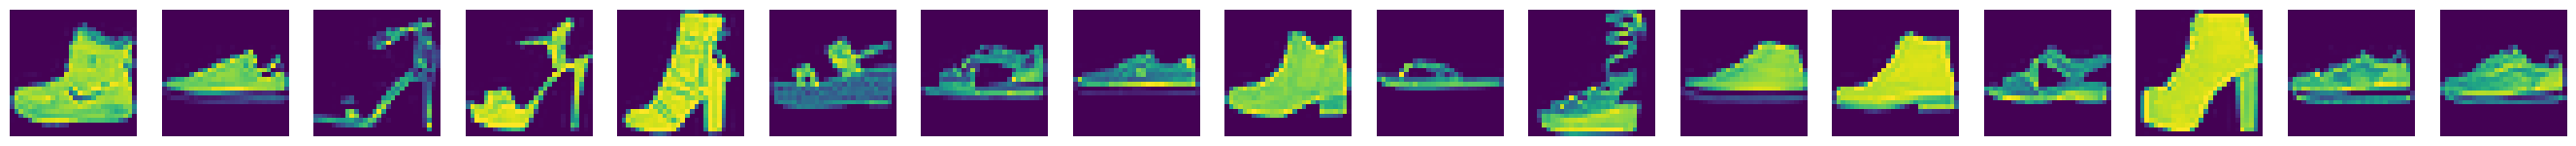

In [ ]:
def show_images(images):
    if len(images.shape) > 3 and images.shape[3] == 1:
        if tf.is_tensor(images):
            images = images.numpy()
        images = np.squeeze(images, axis=3)

    num_images = len(images)
    fig, cells = plt.subplots(ncols=num_images, nrows=1, figsize=(2 * num_images, 2))
    for cell_num in range(num_images):
        cells[cell_num].matshow(images[cell_num])
        cells[cell_num].axis('off')
    plt.show()

# Display images from the training dataset
print("Training Images:")
show_images(train_images[0:17])


In [ ]:
n_stride = 2  # factor to scale image up by in each convolution layer
n_layers_stride = 2  # number of layers scaling the image up
n_smallest_dim = IMG_SIZE // (n_stride * n_layers_stride)
seed_size = IMG_SIZE * (2 ** (n_layers_stride - 1)) * N_CHANNELS

# Set up the individual layers
num_units = n_smallest_dim * n_smallest_dim * seed_size
dense_layer = tf.keras.layers.Dense(units=num_units, activation="relu")

reshape_layer = tf.keras.layers.Reshape(target_shape=(n_smallest_dim, n_smallest_dim, seed_size))

transpose_conv_layer1 = tf.keras.layers.Conv2DTranspose(
        filters=seed_size, kernel_size=3, strides=(n_stride, n_stride),
        padding="SAME", activation="relu")

transpose_conv_layer2 = tf.keras.layers.Conv2DTranspose(
        filters=seed_size/2, kernel_size=3, strides=(n_stride, n_stride),
        padding="SAME", activation="relu")

transpose_conv_layer3 = tf.keras.layers.Conv2DTranspose(
        filters=N_CHANNELS, kernel_size=3, strides=(1, 1),
        padding="SAME", activation="sigmoid")

generator = [dense_layer, reshape_layer,
             transpose_conv_layer1, transpose_conv_layer2, transpose_conv_layer3]

# -- Optimiser (default opt_learning_rate = 0.0001, default opt_beta = 0.5)
opt_learning_rate = 0.0001
opt_beta = 0.5
gen_optimizer = tf.keras.optimizers.Adam(opt_learning_rate, beta_1=opt_beta)

# Build the network
gen = tf.keras.Sequential(generator)
gen.build([train_images.shape[0], 1, 1, seed_size])  # specifies input shape


In [ ]:
# Set up the individual layers

input_layer = tf.keras.layers.InputLayer(input_shape=DIMS)
conv_layer1 = tf.keras.layers.Conv2D(filters=seed_size/2, kernel_size=3,
                                     strides=(n_stride, n_stride),
                                     activation="relu")
conv_layer2 = tf.keras.layers.Conv2D(filters=seed_size, kernel_size=3,
                                     strides=(n_stride, n_stride),
                                     activation="relu")

flatten_layer = tf.keras.layers.Flatten()
dense_layer = tf.keras.layers.Dense(units=1, activation=None)

discriminator = [input_layer, conv_layer1, conv_layer2,
                 flatten_layer, dense_layer]

# -- Optimiser (default opt_learning_rate = 0.001)

opt_learning_rate = 0.0001
disc_optimizer = tf.keras.optimizers.RMSprop(opt_learning_rate)

# Build the network
disc = tf.keras.Sequential(discriminator)
disc.compile(loss='binary_crossentropy', optimizer=disc_optimizer, metrics=['accuracy'])
disc.build(DIMS)  # specifies input shape

Epoch 1/150


  0%|          | 0/36 [00:00<?, ?it/s]

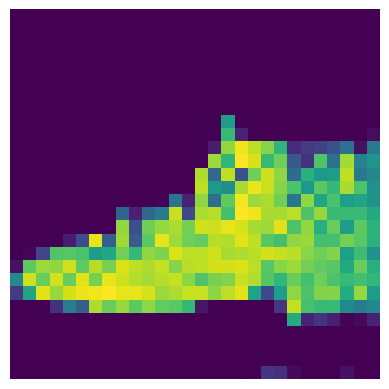

Similarity between generated image and text: 30.728809356689453
Epoch 2/150


  0%|          | 0/36 [00:00<?, ?it/s]

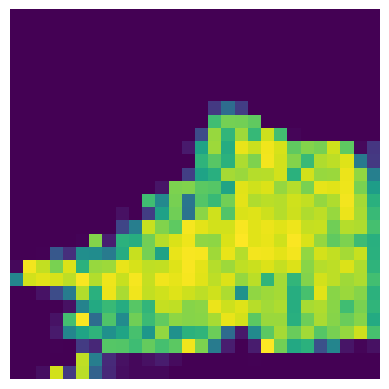

Similarity between generated image and text: 31.04511260986328
Epoch 3/150


  0%|          | 0/36 [00:00<?, ?it/s]

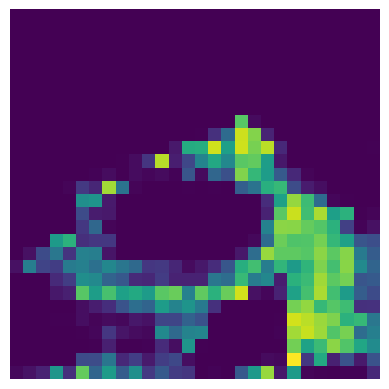

Similarity between generated image and text: 26.763959884643555
Epoch 4/150


  0%|          | 0/36 [00:00<?, ?it/s]

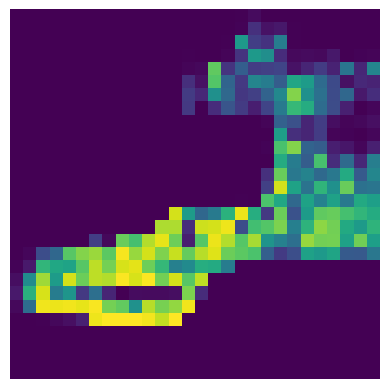

Similarity between generated image and text: 26.729467391967773
Epoch 5/150


  0%|          | 0/36 [00:00<?, ?it/s]

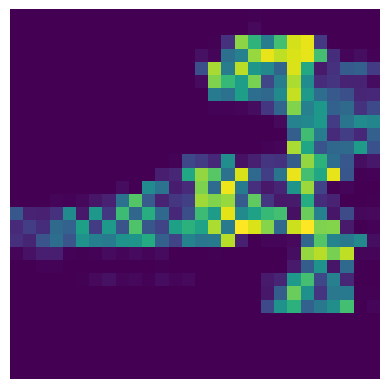

Similarity between generated image and text: 24.974918365478516
Epoch 6/150


  0%|          | 0/36 [00:00<?, ?it/s]

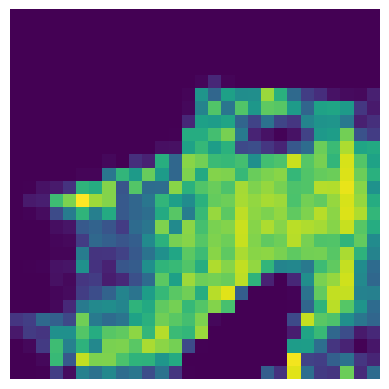

Similarity between generated image and text: 26.56404685974121
Epoch 7/150


  0%|          | 0/36 [00:00<?, ?it/s]

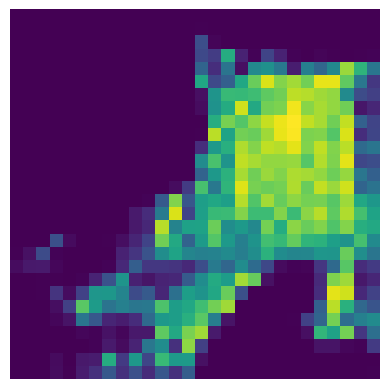

Similarity between generated image and text: 27.296436309814453
Epoch 8/150


  0%|          | 0/36 [00:00<?, ?it/s]

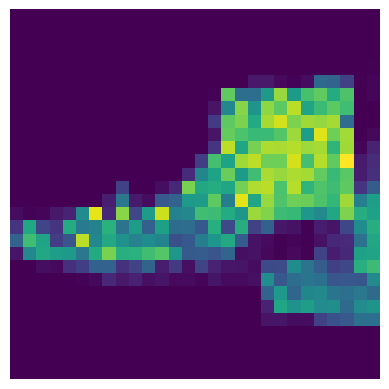

Similarity between generated image and text: 28.261825561523438
Epoch 9/150


  0%|          | 0/36 [00:00<?, ?it/s]

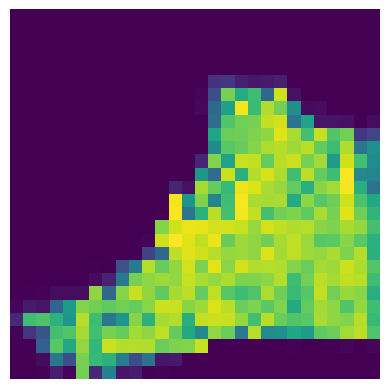

Similarity between generated image and text: 29.617570877075195
Epoch 10/150


  0%|          | 0/36 [00:00<?, ?it/s]

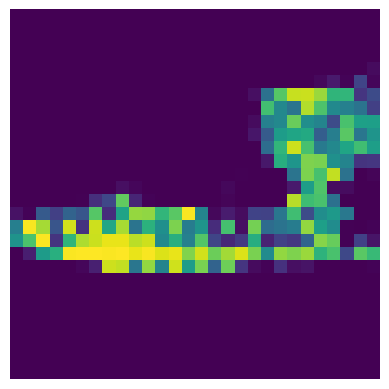

Similarity between generated image and text: 25.95233917236328
Epoch 11/150


  0%|          | 0/36 [00:00<?, ?it/s]

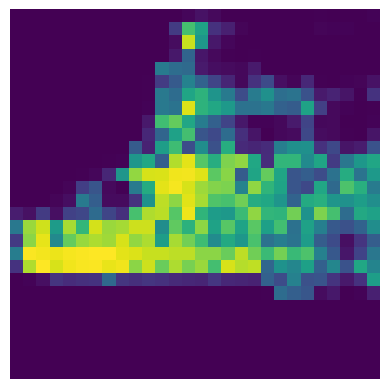

Similarity between generated image and text: 24.80352020263672
Epoch 12/150


  0%|          | 0/36 [00:00<?, ?it/s]

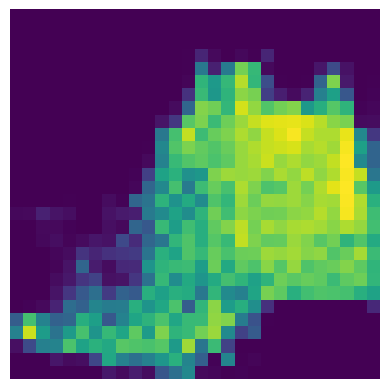

Similarity between generated image and text: 27.39397430419922
Epoch 13/150


  0%|          | 0/36 [00:00<?, ?it/s]

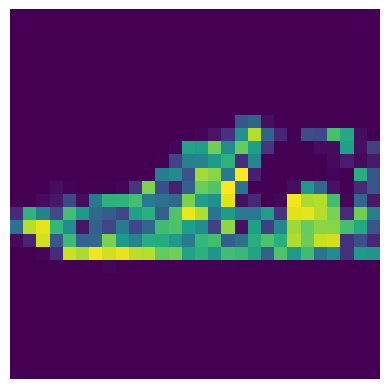

Similarity between generated image and text: 28.413650512695312
Epoch 14/150


  0%|          | 0/36 [00:00<?, ?it/s]

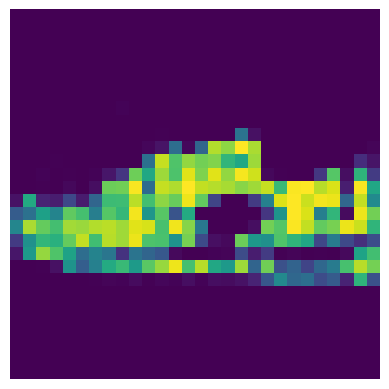

Similarity between generated image and text: 26.392213821411133
Epoch 15/150


  0%|          | 0/36 [00:00<?, ?it/s]

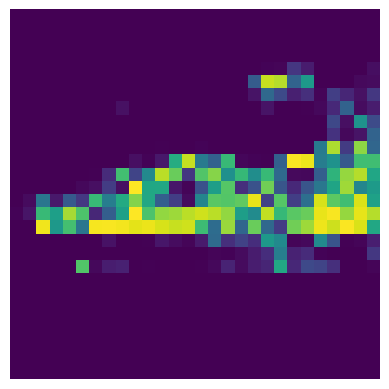

Similarity between generated image and text: 26.621469497680664
Epoch 16/150


  0%|          | 0/36 [00:00<?, ?it/s]

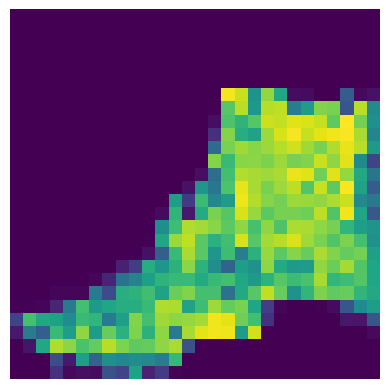

Similarity between generated image and text: 27.87247085571289
Epoch 17/150


  0%|          | 0/36 [00:00<?, ?it/s]

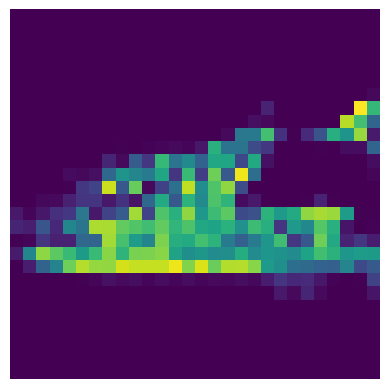

Similarity between generated image and text: 28.772165298461914
Epoch 18/150


  0%|          | 0/36 [00:00<?, ?it/s]

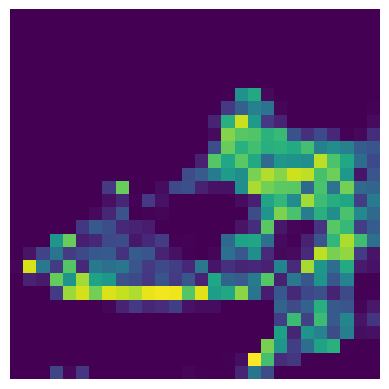

Similarity between generated image and text: 29.385568618774414
Epoch 19/150


  0%|          | 0/36 [00:00<?, ?it/s]

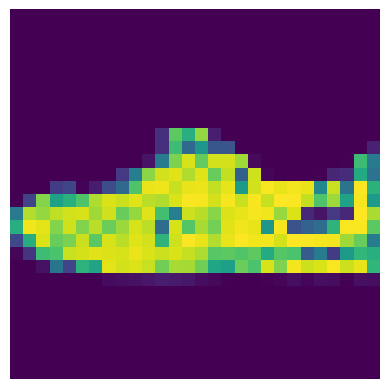

Similarity between generated image and text: 26.67096519470215
Epoch 20/150


  0%|          | 0/36 [00:00<?, ?it/s]

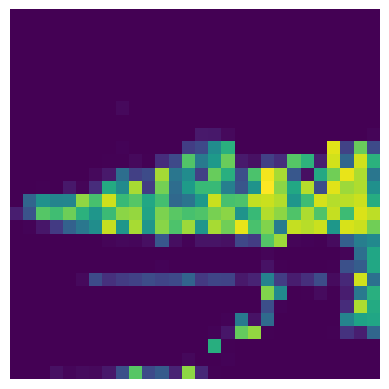

Similarity between generated image and text: 27.34044647216797
Epoch 21/150


  0%|          | 0/36 [00:00<?, ?it/s]

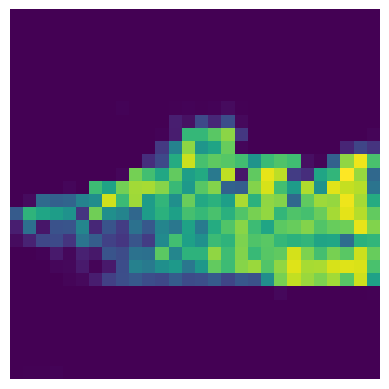

Similarity between generated image and text: 26.763874053955078
Epoch 22/150


  0%|          | 0/36 [00:00<?, ?it/s]

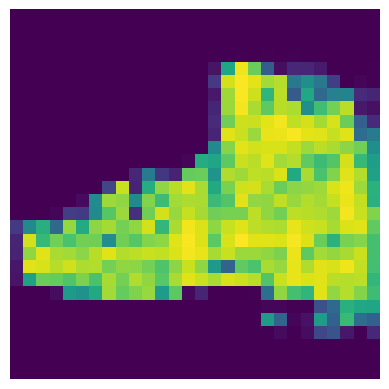

Similarity between generated image and text: 31.037601470947266
Epoch 23/150


  0%|          | 0/36 [00:00<?, ?it/s]

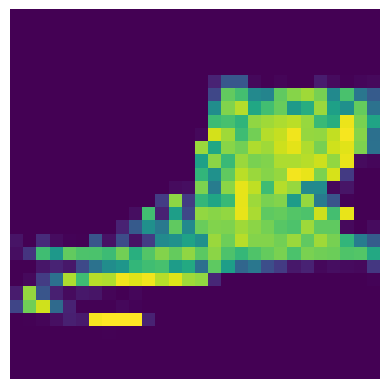

Similarity between generated image and text: 28.89506721496582
Epoch 24/150


  0%|          | 0/36 [00:00<?, ?it/s]

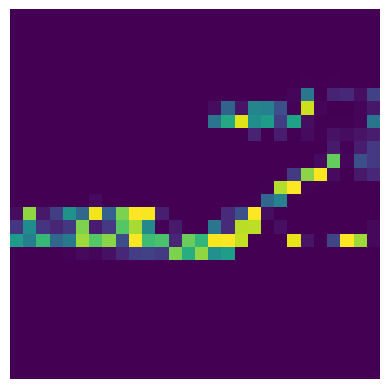

Similarity between generated image and text: 25.948644638061523
Epoch 25/150


  0%|          | 0/36 [00:00<?, ?it/s]

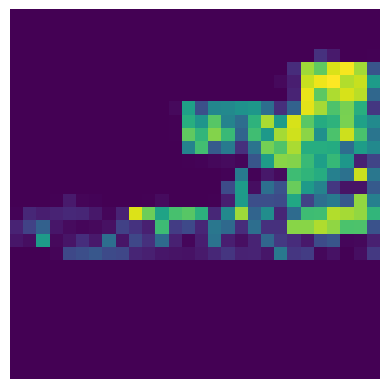

Similarity between generated image and text: 26.024635314941406
Epoch 26/150


  0%|          | 0/36 [00:00<?, ?it/s]

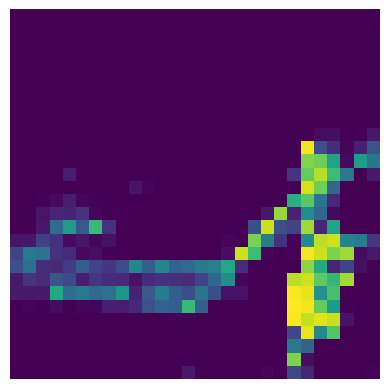

Similarity between generated image and text: 27.508142471313477
Epoch 27/150


  0%|          | 0/36 [00:00<?, ?it/s]

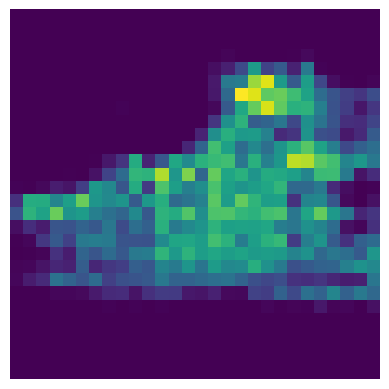

Similarity between generated image and text: 29.777706146240234
Epoch 28/150


  0%|          | 0/36 [00:00<?, ?it/s]

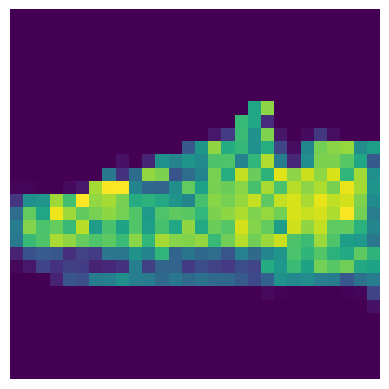

Similarity between generated image and text: 27.123571395874023
Epoch 29/150


  0%|          | 0/36 [00:00<?, ?it/s]

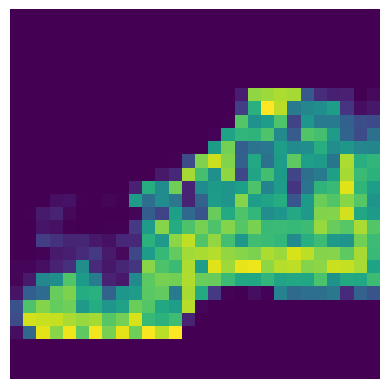

Similarity between generated image and text: 28.69091033935547
Epoch 30/150


  0%|          | 0/36 [00:00<?, ?it/s]

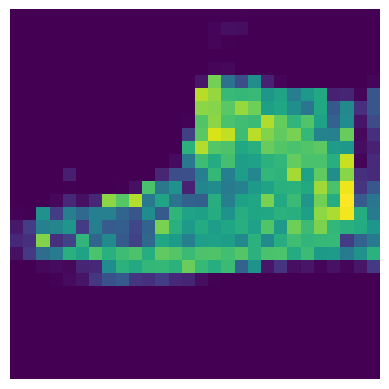

Similarity between generated image and text: 27.6314697265625
Epoch 31/150


  0%|          | 0/36 [00:00<?, ?it/s]

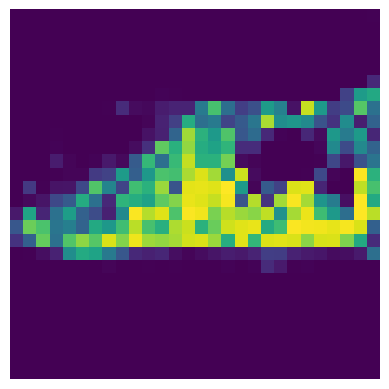

Similarity between generated image and text: 28.264541625976562
Epoch 32/150


  0%|          | 0/36 [00:00<?, ?it/s]

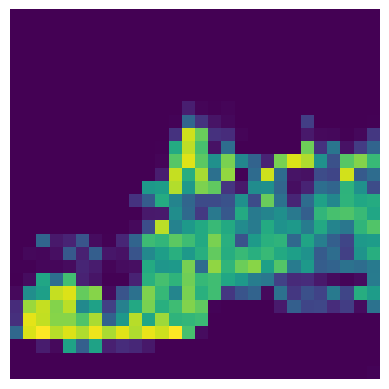

Similarity between generated image and text: 26.694076538085938
Epoch 33/150


  0%|          | 0/36 [00:00<?, ?it/s]

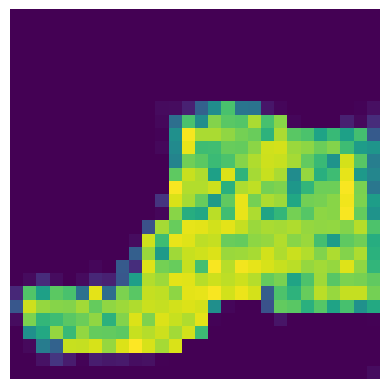

Similarity between generated image and text: 28.217710494995117
Epoch 34/150


  0%|          | 0/36 [00:00<?, ?it/s]

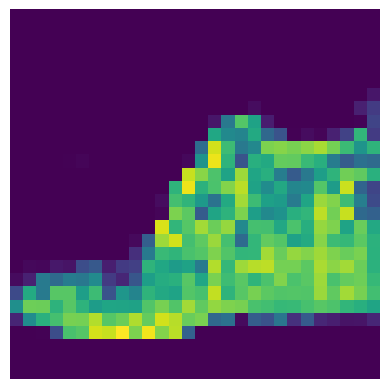

Similarity between generated image and text: 30.631986618041992
Epoch 35/150


  0%|          | 0/36 [00:00<?, ?it/s]

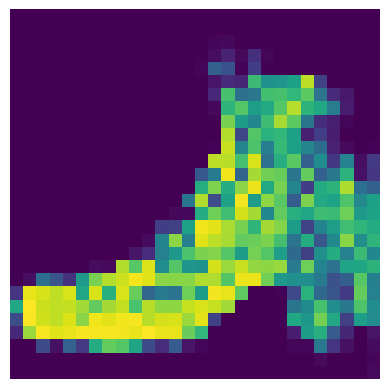

Similarity between generated image and text: 29.48542594909668
Epoch 36/150


  0%|          | 0/36 [00:00<?, ?it/s]

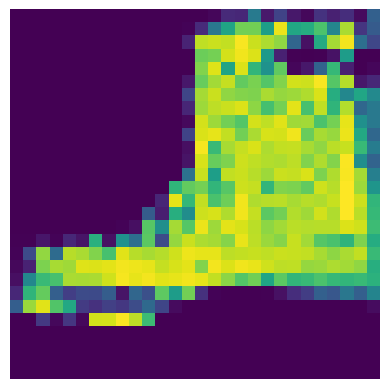

Similarity between generated image and text: 31.979623794555664
Epoch 37/150


  0%|          | 0/36 [00:00<?, ?it/s]

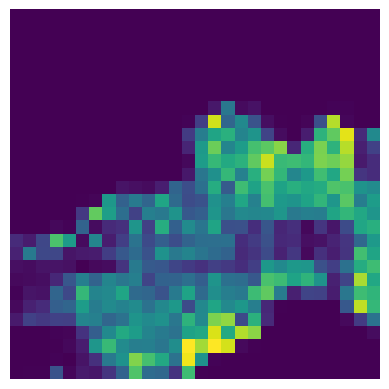

Similarity between generated image and text: 26.400787353515625
Epoch 38/150


  0%|          | 0/36 [00:00<?, ?it/s]

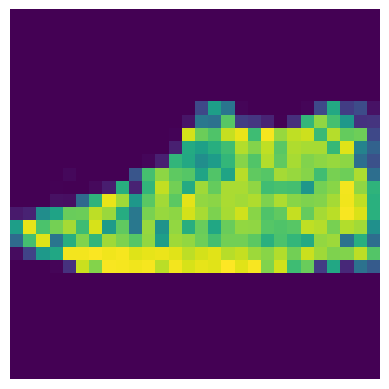

Similarity between generated image and text: 30.20917510986328
Epoch 39/150


  0%|          | 0/36 [00:00<?, ?it/s]

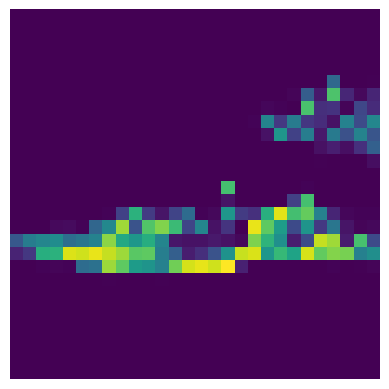

Similarity between generated image and text: 25.527429580688477
Epoch 40/150


  0%|          | 0/36 [00:00<?, ?it/s]

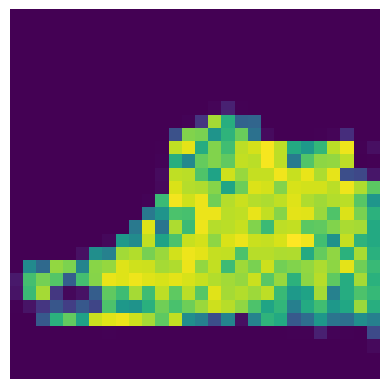

Similarity between generated image and text: 32.341529846191406
Epoch 41/150


  0%|          | 0/36 [00:00<?, ?it/s]

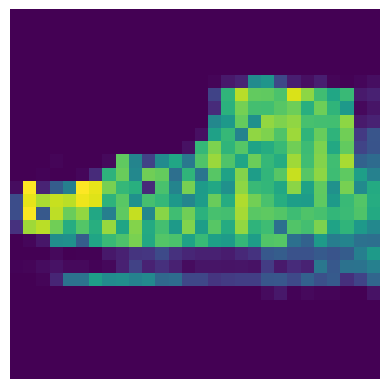

Similarity between generated image and text: 25.48135757446289
Epoch 42/150


  0%|          | 0/36 [00:00<?, ?it/s]

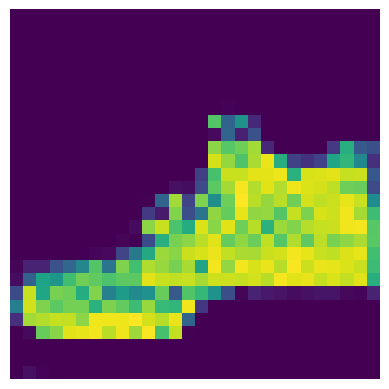

Similarity between generated image and text: 31.003454208374023
Epoch 43/150


  0%|          | 0/36 [00:00<?, ?it/s]

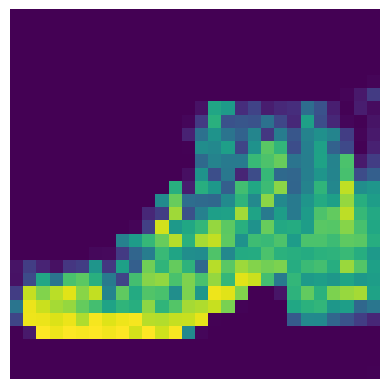

Similarity between generated image and text: 30.31812858581543
Epoch 44/150


  0%|          | 0/36 [00:00<?, ?it/s]

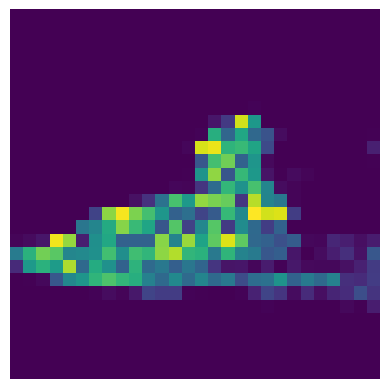

Similarity between generated image and text: 26.36711311340332
Epoch 45/150


  0%|          | 0/36 [00:00<?, ?it/s]

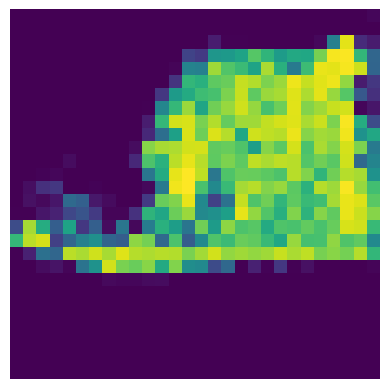

Similarity between generated image and text: 28.233163833618164
Epoch 46/150


  0%|          | 0/36 [00:00<?, ?it/s]

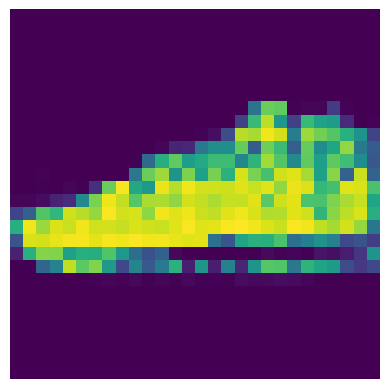

Similarity between generated image and text: 28.26322364807129
Epoch 47/150


  0%|          | 0/36 [00:00<?, ?it/s]

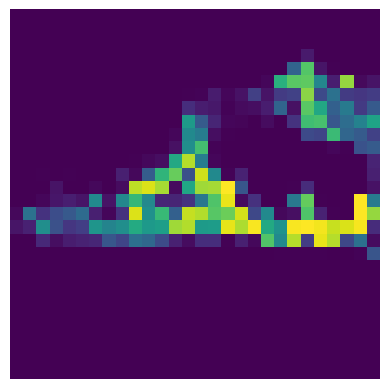

Similarity between generated image and text: 27.939388275146484
Epoch 48/150


  0%|          | 0/36 [00:00<?, ?it/s]

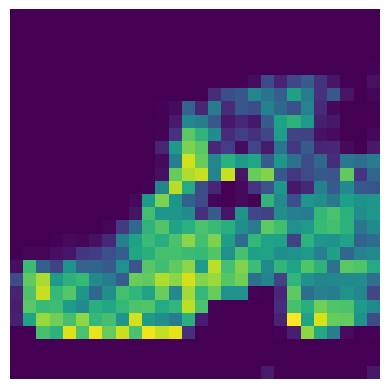

Similarity between generated image and text: 30.005470275878906
Epoch 49/150


  0%|          | 0/36 [00:00<?, ?it/s]

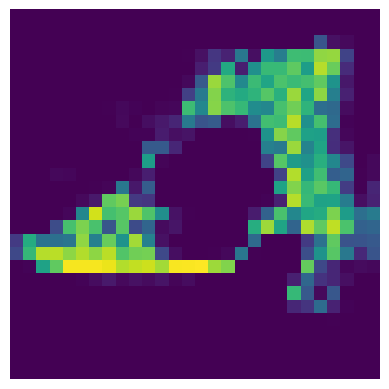

Similarity between generated image and text: 33.44054412841797
Epoch 50/150


  0%|          | 0/36 [00:00<?, ?it/s]

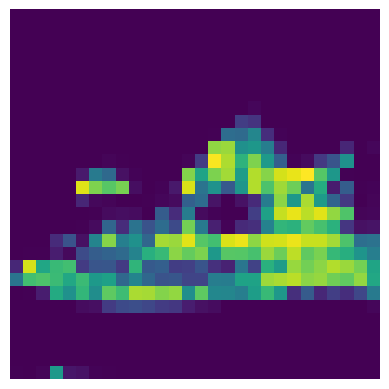

Similarity between generated image and text: 25.240922927856445
Epoch 51/150


  0%|          | 0/36 [00:00<?, ?it/s]

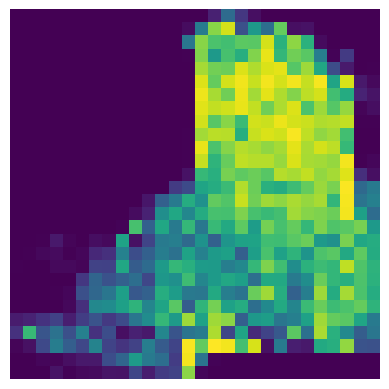

Similarity between generated image and text: 25.642528533935547
Epoch 52/150


  0%|          | 0/36 [00:00<?, ?it/s]

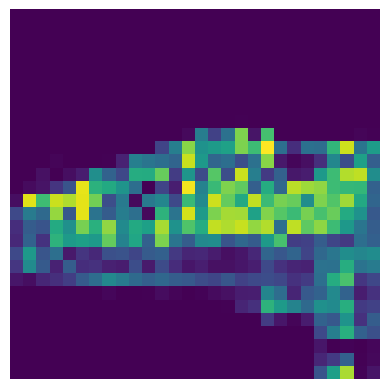

Similarity between generated image and text: 25.22776222229004
Epoch 53/150


  0%|          | 0/36 [00:00<?, ?it/s]

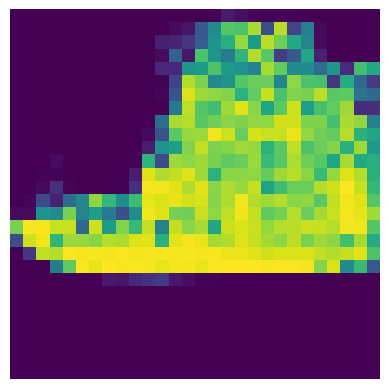

Similarity between generated image and text: 26.57950782775879
Epoch 54/150


  0%|          | 0/36 [00:00<?, ?it/s]

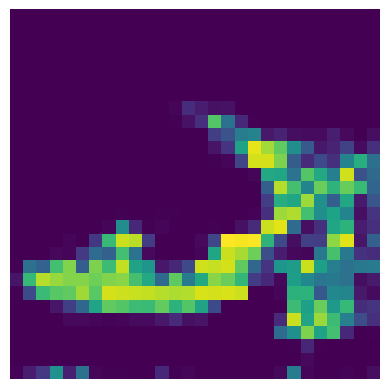

Similarity between generated image and text: 28.843557357788086
Epoch 55/150


  0%|          | 0/36 [00:00<?, ?it/s]

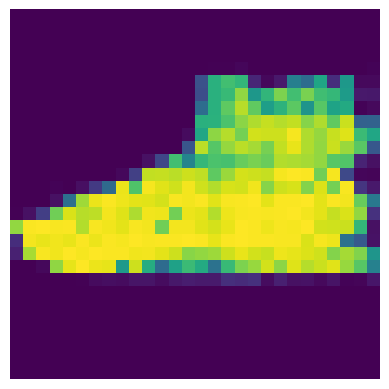

Similarity between generated image and text: 29.24891471862793
Epoch 56/150


  0%|          | 0/36 [00:00<?, ?it/s]

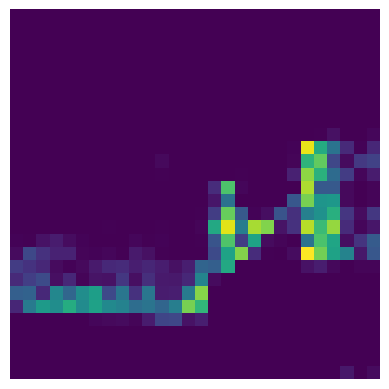

Similarity between generated image and text: 25.482345581054688
Epoch 57/150


  0%|          | 0/36 [00:00<?, ?it/s]

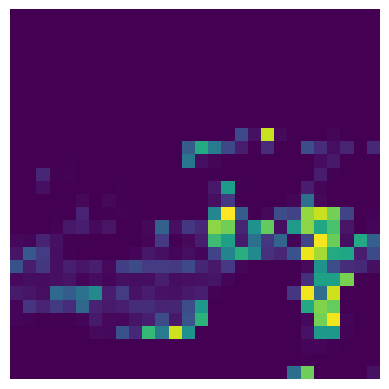

Similarity between generated image and text: 26.909643173217773
Epoch 58/150


  0%|          | 0/36 [00:00<?, ?it/s]

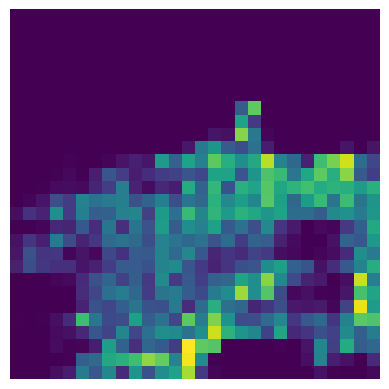

Similarity between generated image and text: 25.607450485229492
Epoch 59/150


  0%|          | 0/36 [00:00<?, ?it/s]

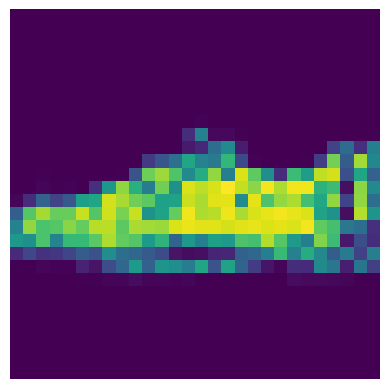

Similarity between generated image and text: 27.285322189331055
Epoch 60/150


  0%|          | 0/36 [00:00<?, ?it/s]

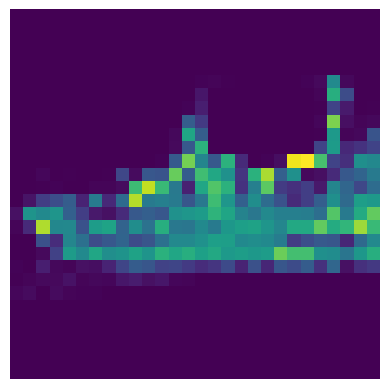

Similarity between generated image and text: 22.756107330322266
Epoch 61/150


  0%|          | 0/36 [00:00<?, ?it/s]

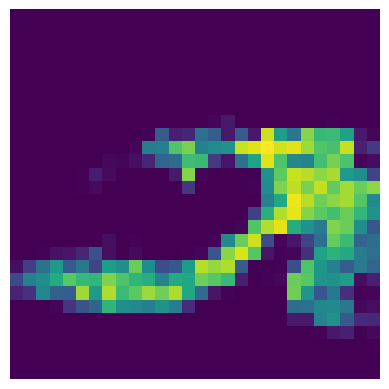

Similarity between generated image and text: 26.43001365661621
Epoch 62/150


  0%|          | 0/36 [00:00<?, ?it/s]

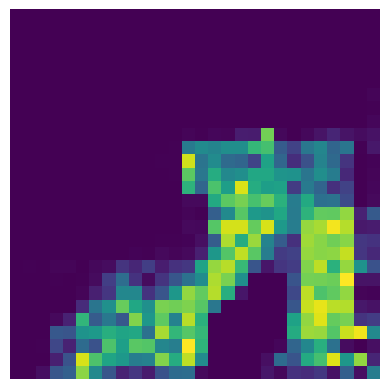

Similarity between generated image and text: 27.59697914123535
Epoch 63/150


  0%|          | 0/36 [00:00<?, ?it/s]

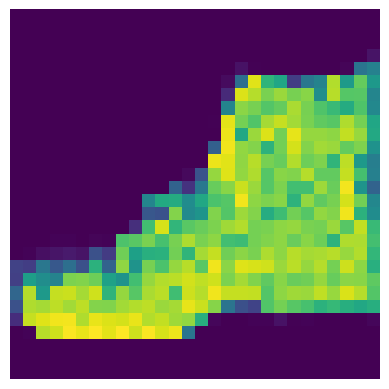

Similarity between generated image and text: 31.392005920410156
Epoch 64/150


  0%|          | 0/36 [00:00<?, ?it/s]

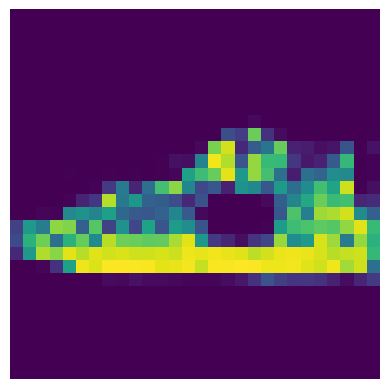

Similarity between generated image and text: 30.97665786743164
Epoch 65/150


  0%|          | 0/36 [00:00<?, ?it/s]

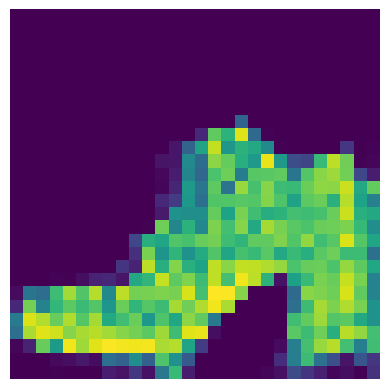

Similarity between generated image and text: 29.032678604125977
Epoch 66/150


  0%|          | 0/36 [00:00<?, ?it/s]

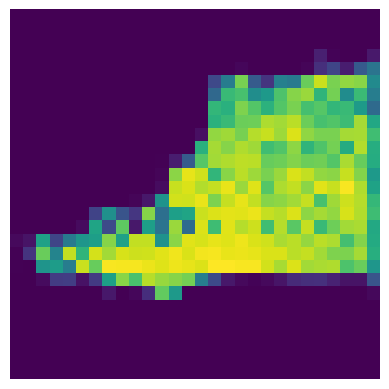

Similarity between generated image and text: 28.513084411621094
Epoch 67/150


  0%|          | 0/36 [00:00<?, ?it/s]

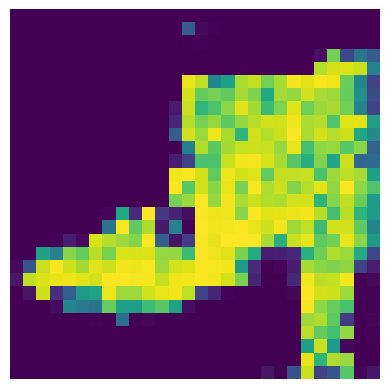

Similarity between generated image and text: 27.852340698242188
Epoch 68/150


  0%|          | 0/36 [00:00<?, ?it/s]

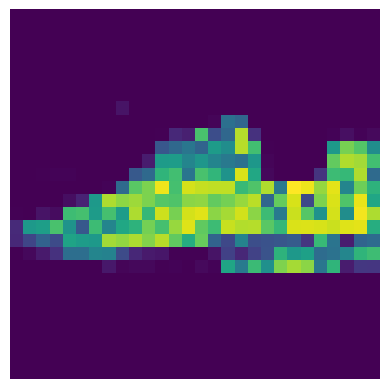

Similarity between generated image and text: 28.27849006652832
Epoch 69/150


  0%|          | 0/36 [00:00<?, ?it/s]

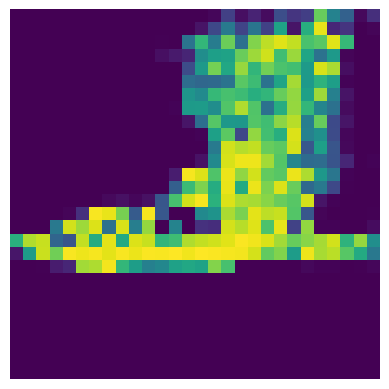

Similarity between generated image and text: 30.321212768554688
Epoch 70/150


  0%|          | 0/36 [00:00<?, ?it/s]

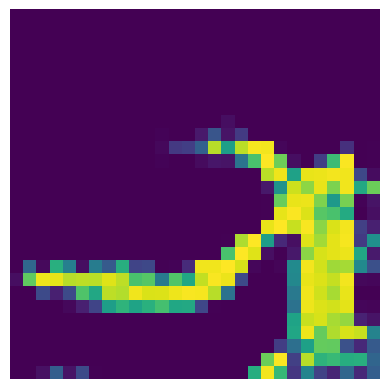

Similarity between generated image and text: 28.12723731994629
Epoch 71/150


  0%|          | 0/36 [00:00<?, ?it/s]

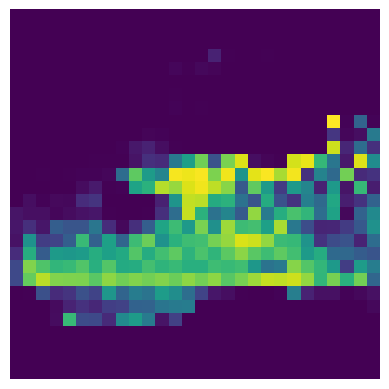

Similarity between generated image and text: 27.40300941467285
Epoch 72/150


  0%|          | 0/36 [00:00<?, ?it/s]

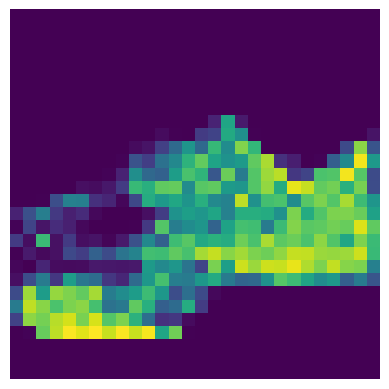

Similarity between generated image and text: 29.118206024169922
Epoch 73/150


  0%|          | 0/36 [00:00<?, ?it/s]

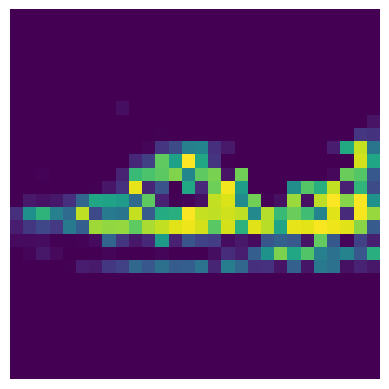

Similarity between generated image and text: 25.628198623657227
Epoch 74/150


  0%|          | 0/36 [00:00<?, ?it/s]

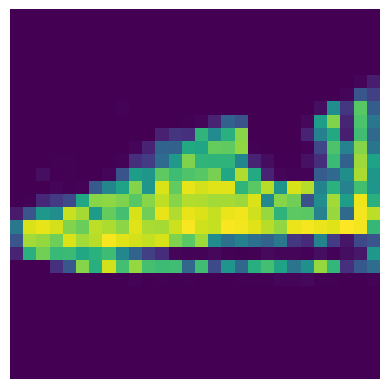

Similarity between generated image and text: 29.411062240600586
Epoch 75/150


  0%|          | 0/36 [00:00<?, ?it/s]

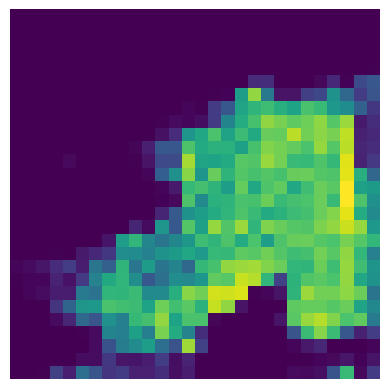

Similarity between generated image and text: 27.28879165649414
Epoch 76/150


  0%|          | 0/36 [00:00<?, ?it/s]

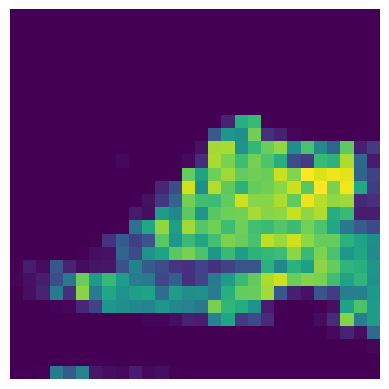

Similarity between generated image and text: 27.625452041625977
Epoch 77/150


  0%|          | 0/36 [00:00<?, ?it/s]

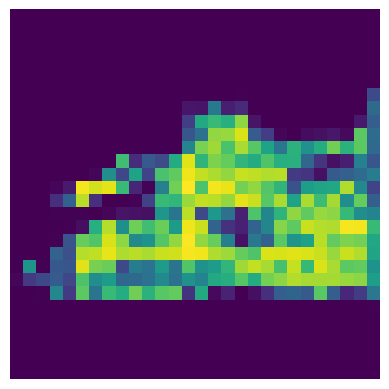

Similarity between generated image and text: 27.03489112854004
Epoch 78/150


  0%|          | 0/36 [00:00<?, ?it/s]

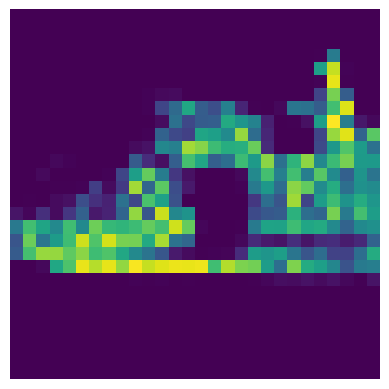

Similarity between generated image and text: 24.853633880615234
Epoch 79/150


  0%|          | 0/36 [00:00<?, ?it/s]

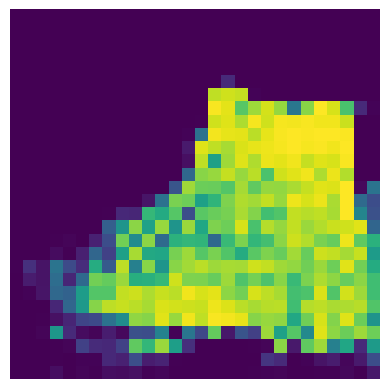

Similarity between generated image and text: 32.266136169433594
Epoch 80/150


  0%|          | 0/36 [00:00<?, ?it/s]

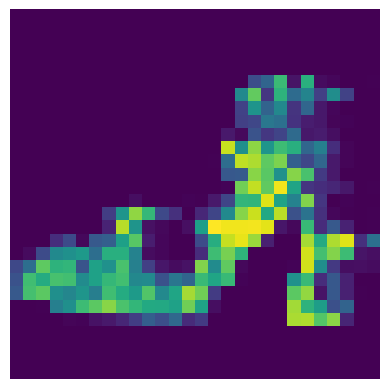

Similarity between generated image and text: 27.483617782592773
Epoch 81/150


  0%|          | 0/36 [00:00<?, ?it/s]

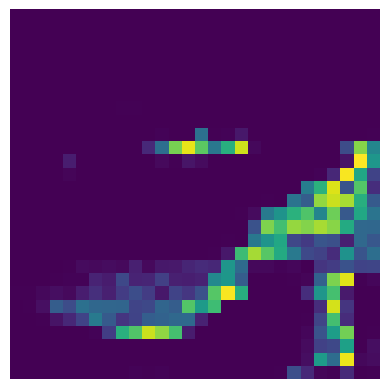

Similarity between generated image and text: 27.86834716796875
Epoch 82/150


  0%|          | 0/36 [00:00<?, ?it/s]

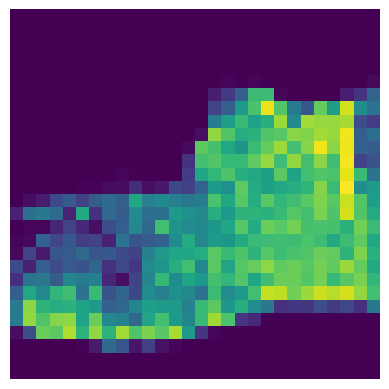

Similarity between generated image and text: 25.930404663085938
Epoch 83/150


  0%|          | 0/36 [00:00<?, ?it/s]

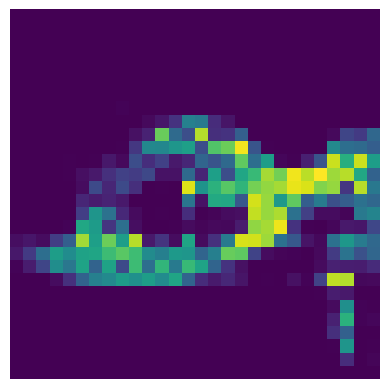

Similarity between generated image and text: 28.42474365234375
Epoch 84/150


  0%|          | 0/36 [00:00<?, ?it/s]

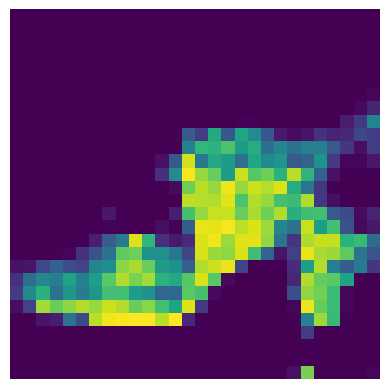

Similarity between generated image and text: 30.005264282226562
Epoch 85/150


  0%|          | 0/36 [00:00<?, ?it/s]

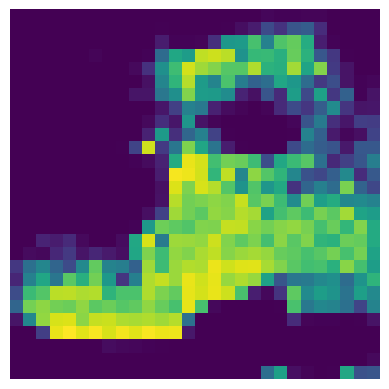

Similarity between generated image and text: 31.0881290435791
Epoch 86/150


  0%|          | 0/36 [00:00<?, ?it/s]

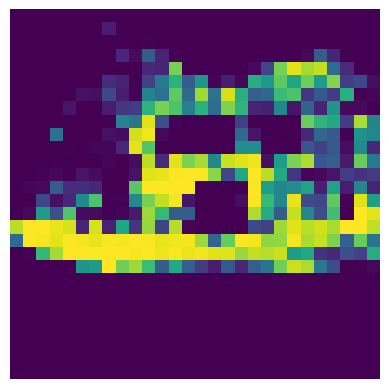

Similarity between generated image and text: 27.367551803588867
Epoch 87/150


  0%|          | 0/36 [00:00<?, ?it/s]

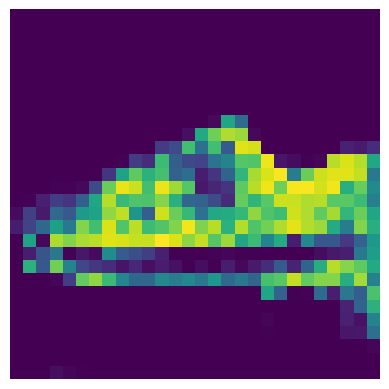

Similarity between generated image and text: 31.067184448242188
Epoch 88/150


  0%|          | 0/36 [00:00<?, ?it/s]

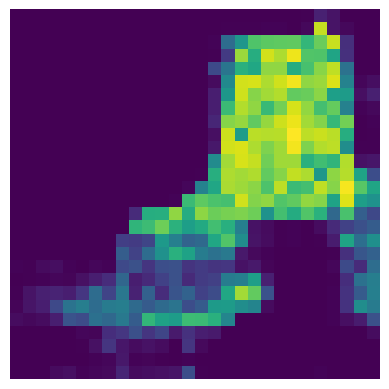

Similarity between generated image and text: 30.10352325439453
Epoch 89/150


  0%|          | 0/36 [00:00<?, ?it/s]

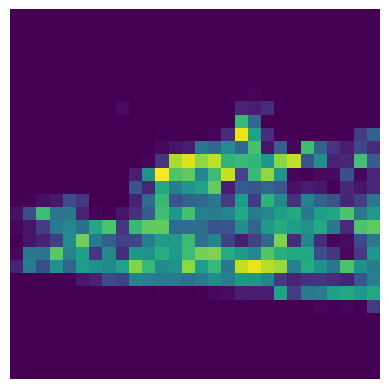

Similarity between generated image and text: 26.29310417175293
Epoch 90/150


  0%|          | 0/36 [00:00<?, ?it/s]

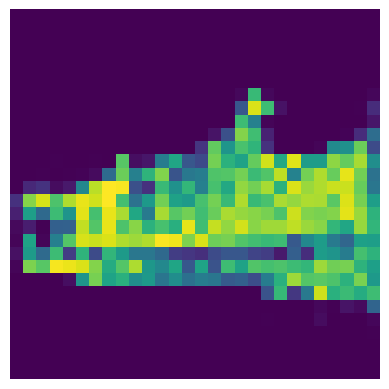

Similarity between generated image and text: 26.71603012084961
Epoch 91/150


  0%|          | 0/36 [00:00<?, ?it/s]

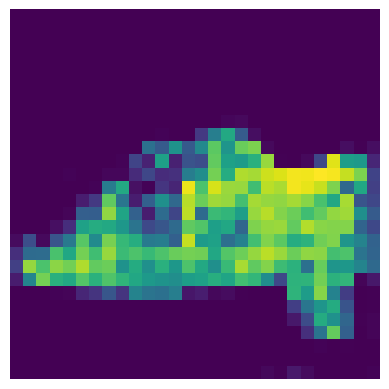

Similarity between generated image and text: 26.831087112426758
Epoch 92/150


  0%|          | 0/36 [00:00<?, ?it/s]

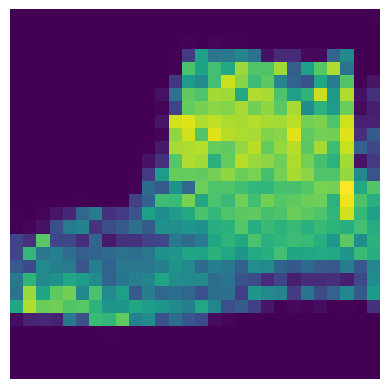

Similarity between generated image and text: 28.421663284301758
Epoch 93/150


  0%|          | 0/36 [00:00<?, ?it/s]

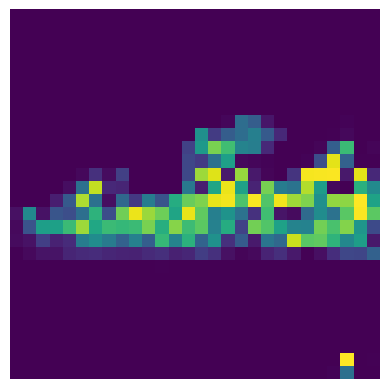

Similarity between generated image and text: 26.484577178955078
Epoch 94/150


  0%|          | 0/36 [00:00<?, ?it/s]

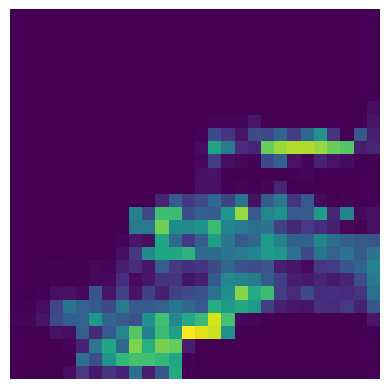

Similarity between generated image and text: 26.528425216674805
Epoch 95/150


  0%|          | 0/36 [00:00<?, ?it/s]

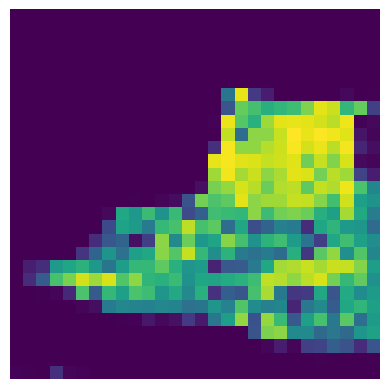

Similarity between generated image and text: 28.169586181640625
Epoch 96/150


  0%|          | 0/36 [00:00<?, ?it/s]

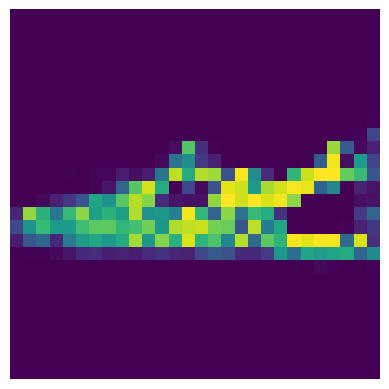

Similarity between generated image and text: 27.34666633605957
Epoch 97/150


  0%|          | 0/36 [00:00<?, ?it/s]

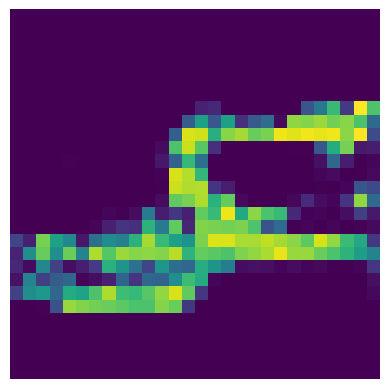

Similarity between generated image and text: 24.741912841796875
Epoch 98/150


  0%|          | 0/36 [00:00<?, ?it/s]

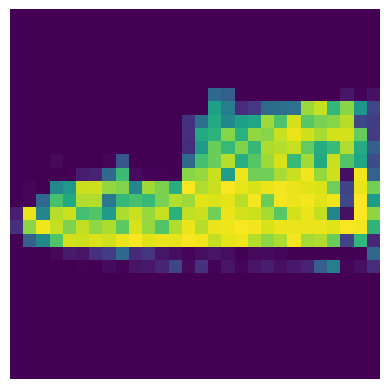

Similarity between generated image and text: 31.96135902404785
Epoch 99/150


  0%|          | 0/36 [00:00<?, ?it/s]

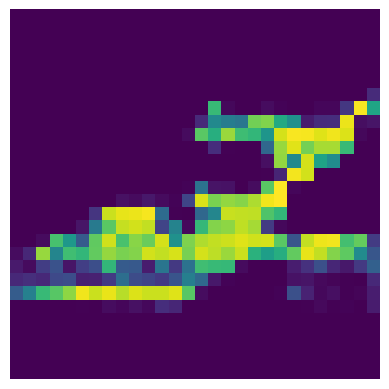

Similarity between generated image and text: 26.005355834960938
Epoch 100/150


  0%|          | 0/36 [00:00<?, ?it/s]

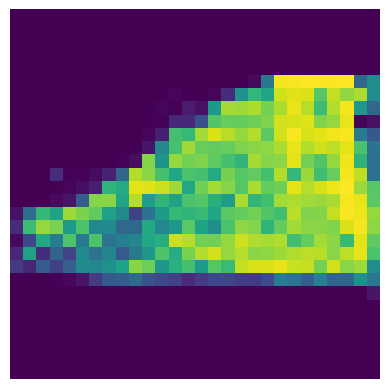

Similarity between generated image and text: 29.310348510742188
Epoch 101/150


  0%|          | 0/36 [00:00<?, ?it/s]

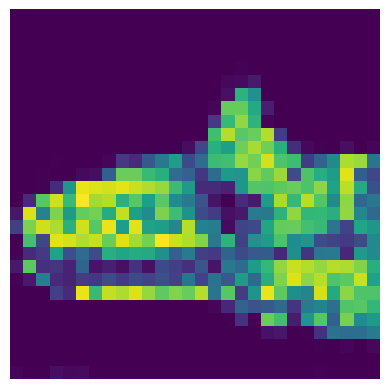

Similarity between generated image and text: 28.536209106445312
Epoch 102/150


  0%|          | 0/36 [00:00<?, ?it/s]

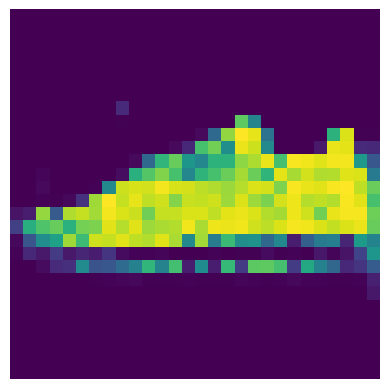

Similarity between generated image and text: 29.260215759277344
Epoch 103/150


  0%|          | 0/36 [00:00<?, ?it/s]

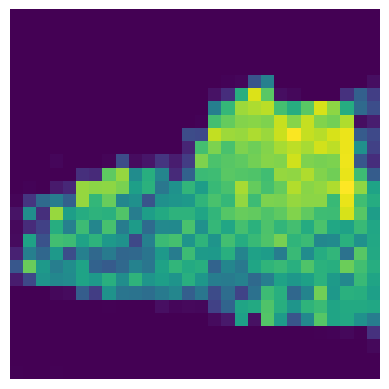

Similarity between generated image and text: 26.67106819152832
Epoch 104/150


  0%|          | 0/36 [00:00<?, ?it/s]

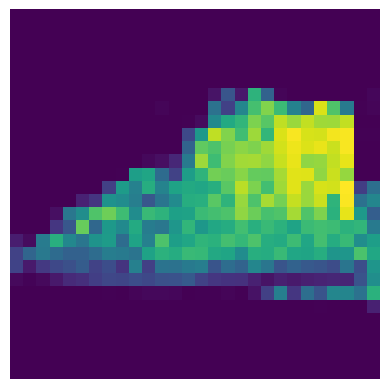

Similarity between generated image and text: 27.08376121520996
Epoch 105/150


  0%|          | 0/36 [00:00<?, ?it/s]

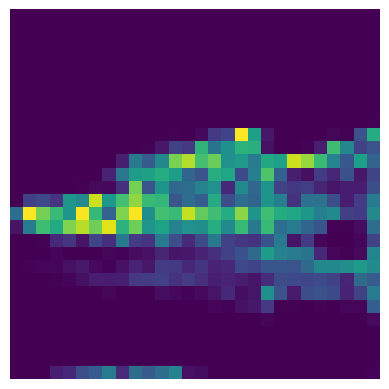

Similarity between generated image and text: 26.574365615844727
Epoch 106/150


  0%|          | 0/36 [00:00<?, ?it/s]

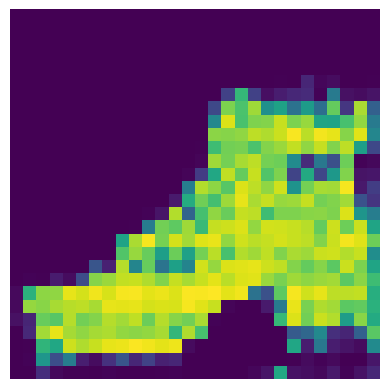

Similarity between generated image and text: 29.06281852722168
Epoch 107/150


  0%|          | 0/36 [00:00<?, ?it/s]

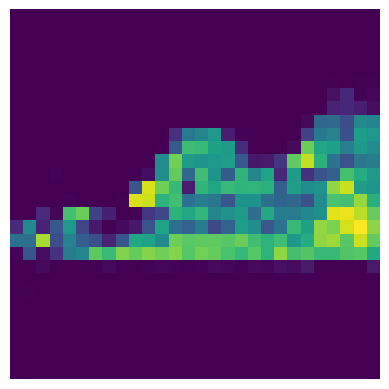

Similarity between generated image and text: 26.524181365966797
Epoch 108/150


  0%|          | 0/36 [00:00<?, ?it/s]

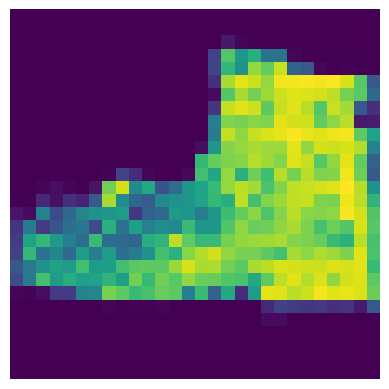

Similarity between generated image and text: 28.645742416381836
Epoch 109/150


  0%|          | 0/36 [00:00<?, ?it/s]

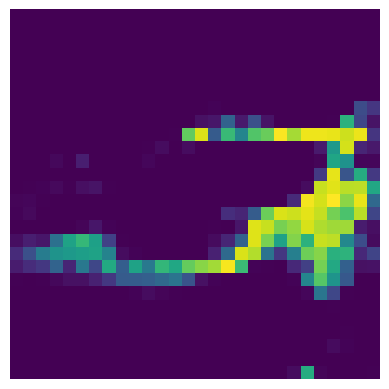

Similarity between generated image and text: 25.91693115234375
Epoch 110/150


  0%|          | 0/36 [00:00<?, ?it/s]

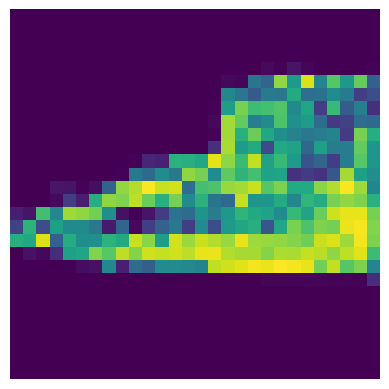

Similarity between generated image and text: 26.020566940307617
Epoch 111/150


  0%|          | 0/36 [00:00<?, ?it/s]

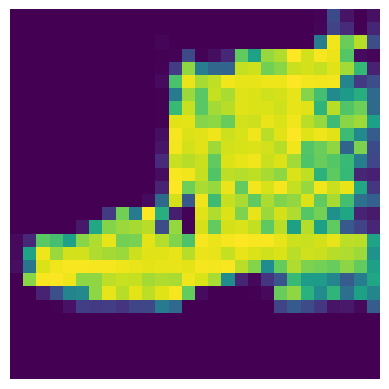

Similarity between generated image and text: 31.165386199951172
Epoch 112/150


  0%|          | 0/36 [00:00<?, ?it/s]

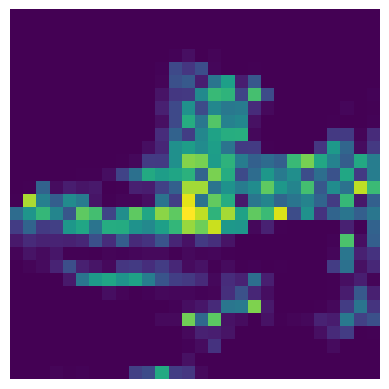

Similarity between generated image and text: 25.06587791442871
Epoch 113/150


  0%|          | 0/36 [00:00<?, ?it/s]

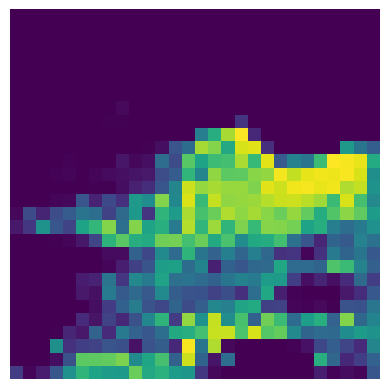

Similarity between generated image and text: 26.586830139160156
Epoch 114/150


  0%|          | 0/36 [00:00<?, ?it/s]

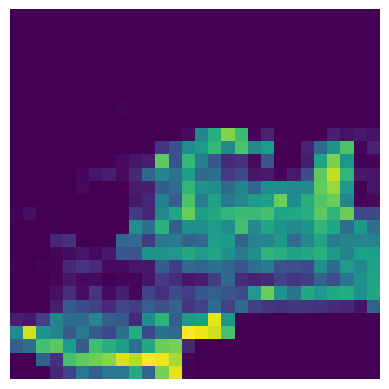

Similarity between generated image and text: 27.140195846557617
Epoch 115/150


  0%|          | 0/36 [00:00<?, ?it/s]

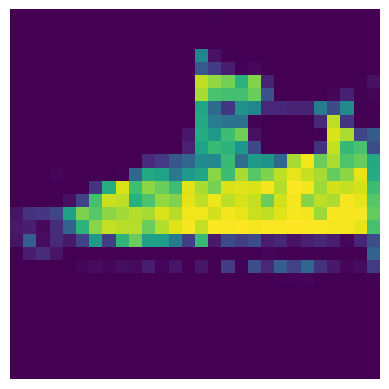

Similarity between generated image and text: 29.421703338623047
Epoch 116/150


  0%|          | 0/36 [00:00<?, ?it/s]

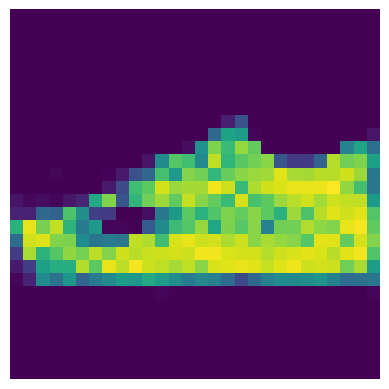

Similarity between generated image and text: 28.747135162353516
Epoch 117/150


  0%|          | 0/36 [00:00<?, ?it/s]

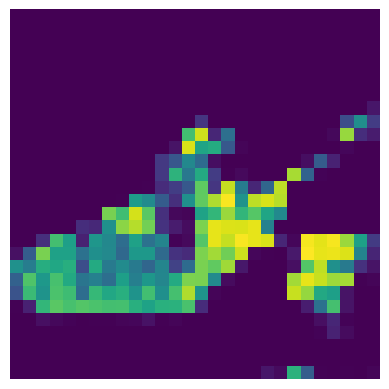

Similarity between generated image and text: 27.46122169494629
Epoch 118/150


  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
import torch
import clip
import numpy as np
from PIL import Image
import tensorflow as tf
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

# Define GAN class
class GAN(tf.keras.Model):
    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

    def call(self, x):
        return self.gen(x)

    def generate(self, z, text_embedding):
        return self.gen(z, text_embedding)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x, text_embedding):
        seed = tf.random.normal([x.shape[0], 1, 1, self.seed_size])
        fakes = self.generate(seed, text_embedding)
        logits_reals = self.discriminate(x)
        logits_fakes = self.discriminate(fakes)
        disc_real_loss = gan_loss(logits=logits_reals, is_real=True)
        disc_fake_loss = gan_loss(logits=logits_fakes, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss
        gen_loss = gan_loss(logits=logits_fakes, is_real=True)
        return disc_loss, gen_loss

    def compute_gradients(self, x, text_embedding):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x, text_embedding)
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)
        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.gen.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(disc_gradients, self.disc.trainable_variables))

    @tf.function
    def train(self, train_x, text_embedding):
        gen_gradients, disc_gradients = self.compute_gradients(train_x, text_embedding)
        self.apply_gradients(gen_gradients, disc_gradients)

# Define a function to get CLIP text embedding
def get_clip_text_embedding(text):
    with torch.no_grad():
        text_embedding = model.encode_text(clip.tokenize([text]).to(device))
    return text_embedding

# Helper function for computing cross entropy loss
def gan_loss(logits, is_real=True):
    labels = tf.ones_like(logits) if is_real else tf.zeros_like(logits)
    return tf.nn.sigmoid_cross_entropy_with_logits(labels, logits)

# Define the GAN model and optimizer
gan_model = GAN(gen=gen, disc=disc, gen_optimizer=gen_optimizer, disc_optimizer=disc_optimizer, seed_size=seed_size)

# Define the text for generating images
text = "sneakers"

# Define the training loop
n_epochs = 150
for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1, n_epochs))
    # Calculate CLIP text embedding once per epoch
    text_embedding = get_clip_text_embedding(text)
    for image_batch in tqdm(train_dataset):
        gan_model.train(image_batch, text_embedding)

    # Generate images based on CLIP text embedding
    seed = tf.random.normal([1, 1, 1, gan_model.seed_size])
    generated_image = gan_model.generate(seed, text_embedding)

    # Convert the image to PIL format and save
    pil_image = Image.fromarray((generated_image.numpy() * 255).astype(np.uint8).squeeze())
    pil_image.save(f"generated_image_{epoch}.png")

    # Optionally, display the generated image
    plt.imshow(pil_image)
    plt.axis('off')
    plt.show()

    # Calculate the similarity score between the generated image and the text using CLIP
    with torch.no_grad():
        image_tensor = preprocess(pil_image).unsqueeze(0).to(device)
        image_features = model.encode_image(image_tensor).float()
        similarity = (text_embedding.cpu().numpy() @ image_features.cpu().numpy().T).item()
    print(f"Similarity between generated image and text: {similarity}")

In [ ]:
!pip install --upgrade nbconvert



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.5.4
    Uninstalling nbconvert-6.5.4:
      Successfully uninstalled nbconvert-6.5.4


In [ ]:
!jupyter nbconvert --to html /content/drive/MyDrive/ec7022p.ipynb



[NbConvertApp] Converting notebook /content/drive/MyDrive/ec7022p.ipynb to html
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/jupyter_core/application.py", line 283, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filename)
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertapp.py", line 563, in convert_single_notebook
    output, resources = self.export_single_notebook(
  File "/usr/local/lib/python3.10/dist-packages/nbconvert/nbconvertap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
